In [1]:
#package imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
import itertools
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

from ase import Atoms
from ase.io import read, write
from ase.visualize import view

#From helpers.py file (help functions)
import helpers

# 1 - Load Data & Import Top Performing Model

2023-05-18 11:29:55.620935: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 11:29:55.669851: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open saved_NN_val2/checkpoint/: Failed precondition: saved_NN_val2/checkpoint; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2023-05-18 11:29:55.736256: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


MAE test: 0.09626685193092509
MAE train: 0.058837315170089305


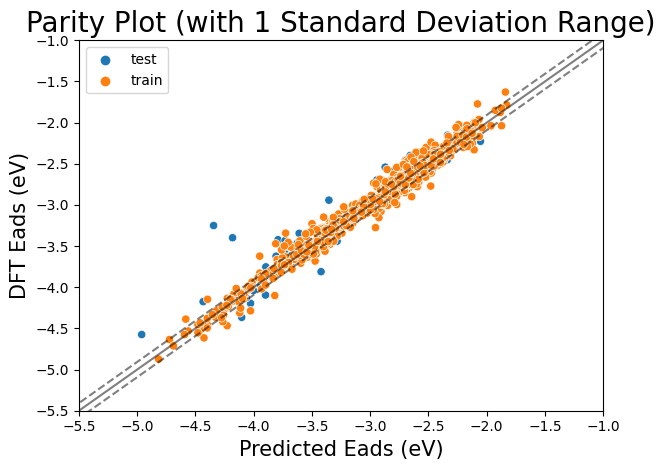

In [2]:
#Import Data --------------------
with open('load_2.npy', 'rb') as f:
    X_train = np.load(f)
    X_val = np.load(f)
    X_test = np.load(f)
    Y_train = np.load(f)
    Y_val = np.load(f)
    Y_test = np.load(f)
#--------------------------------

#Import Model -------------------
def get_new_model():
    model = Sequential([
                        Dense(64,input_shape=(52,),activation='relu', use_bias=False),
                        Dense(64,activation='relu',use_bias=False),
                        Dense(12,activation='relu',use_bias=False),
                        Dense(1,activation="linear",use_bias=False),])
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='mse', metrics=['mae','mse'])
    return model

model = get_new_model()
checkpoint_filepath = 'saved_NN_val2/checkpoint/'
model.load_weights(checkpoint_filepath)
#--------------------------------

#Model Performance --------------

#Predicted Values
yhat_train =list( model.predict(X_train)[:,0] )
yhat_test  =list( model.predict(X_test)[:,0]  ) 
preds=yhat_test+yhat_train

#Real Values
y_test= list(Y_test[:,0])
y_train=list(Y_train[:,0])
real = y_test+y_train

labels=[]
for i in range(len(yhat_test)):
    labels.append('test')
for i in range(len(yhat_train)):
    labels.append('train')

d = {'Predicted': preds, 'Real': real,'Label':labels}
df_scatter = pd.DataFrame(data=d)

#MAE Values
test_df = df_scatter[df_scatter['Label']=='test']
train_df = df_scatter[df_scatter['Label']=='train']
print('MAE test: ' +str(mean_absolute_error(test_df['Predicted'], test_df['Real'])))
print('MAE train: ' + str(mean_absolute_error(train_df['Predicted'], train_df['Real'])))

#Calculated std dev
std_dev = np.std ( df_scatter['Predicted'] - df_scatter['Real'] )
                
x = [-8,4]
y = [-8-std_dev,4-std_dev]
hue=['low','low']
d1 = {'x':x,'lines': y,'hue':hue}
df1 = pd.DataFrame(data=d1)

x = [-8,4]
y = [-8+std_dev,4+std_dev]
hue=['up','up']
d2 = {'x':x,'lines': y,'hue':hue}
df2 = pd.DataFrame(data=d2)

#Plot using seaborn scatterplot
x4=sns.scatterplot(data=df_scatter, x='Predicted',y='Real',hue='Label',marker='o', color='b')
x4.set(xlim=(-5.5,-1))
x4.set(ylim=(-5.5,-1))
x4.plot([-8,4],[-8,4],color='black',alpha=0.5) 
x4=sns.lineplot(x='x',y='lines',data=df1,color='black',alpha  = 0.5)
x4.lines[1].set_linestyle("--")
x4=sns.lineplot(x='x',y='lines',data=df2,color='black',alpha  = 0.5)
x4.lines[2].set_linestyle("--")
x4.set_xlabel("Predicted Eads (eV)", fontsize = 15)
x4.set_ylabel("DFT Eads (eV)", fontsize = 15)
x4.set_title("Parity Plot (with 1 Standard Deviation Range)", fontsize = 20)
plt.tight_layout()
#--------------------------------

# 2 - n element -> n+1 element catalyst discovery

Rh average replacements: 2.137
Ru average replacements: 2.176


<AxesSubplot: ylabel='Count'>

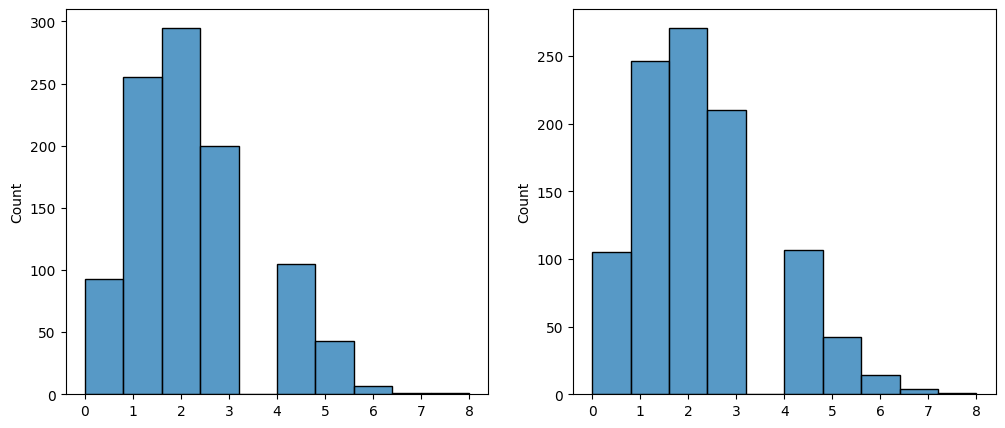

In [8]:
#Visualization of random datapoint generation for n+1 element alloys from n element alloy training set
e1 = 'Rh'
e2 = 'Ru'

avg_e1=[]
avg_e2 =[]
for j in range(1000):
    x1,x2=helpers.random_multi_ele_datapoint(e1,e2)
    c1 =0
    c2 =0
    for i in x1:
        if i == e1:
            c1+=1
        if i == e2:
            c2+=1
    avg_e1.append(c1)
    avg_e2.append(c2)   
print(e1+' average replacements: '+str(np.mean(avg_e1)))
print(e2+' average replacements: '+str(np.mean(avg_e2)))
fig,axs = plt.subplots(1,2, figsize = (12,5))
sns.histplot(data=avg_e1,bins=10, ax=axs[0],label=e1)
sns.histplot(data=avg_e2,bins=10, ax=axs[1],label=e2)

In [16]:
#Generate df of all possible elemental combinations with predicted performance predictions
'''t1=time.time()

eles = ['Ru','Rh','Os','Ir','Pd','Pt','Ag','Au']
ele_combinations =list(itertools.combinations(eles, 2))

predictions = []
struct_pred = [] #list of lists
ele_combo=[]

for j in range(len(ele_combinations)):
    e1=ele_combinations[j][0]
    e2=ele_combinations[j][1]
    e1_e2= e1+'_'+e2
    print('starting '+e1_e2+'...')
    for i in range(1000):
        template1,datapoint = random_multi_ele_datapoint(e1,e2)
        predictions.append(model.predict(datapoint)[0][0])
        struct_pred.append(template1)
        ele_combo.append(e1_e2)
t2=time.time()

dic = {'Eads pred (eV)':predictions,'Elements':ele_combo}
df = pd.DataFrame(dic)
print ('Runtime (s): '+str(t2-t1))

#save files
df.to_csv('3_ele_optimization.csv')
with open('test.txt', 'w') as f:
    f.write(json.dumps(struct_pred))'''

starting Ru_Rh...
starting Ru_Os...
starting Ru_Ir...
starting Ru_Pd...
starting Ru_Pt...
starting Ru_Ag...
starting Ru_Au...
starting Rh_Os...
starting Rh_Ir...
starting Rh_Pd...
starting Rh_Pt...
starting Rh_Ag...
starting Rh_Au...
starting Os_Ir...
starting Os_Pd...
starting Os_Pt...
starting Os_Ag...
starting Os_Au...
starting Ir_Pd...
starting Ir_Pt...
starting Ir_Ag...
starting Ir_Au...
starting Pd_Pt...
starting Pd_Ag...
starting Pd_Au...
starting Pt_Ag...
starting Pt_Au...
starting Ag_Au...
Runtime (s): 1030.9710612297058


<AxesSubplot: xlabel='Eads pred (eV)', ylabel='Count'>

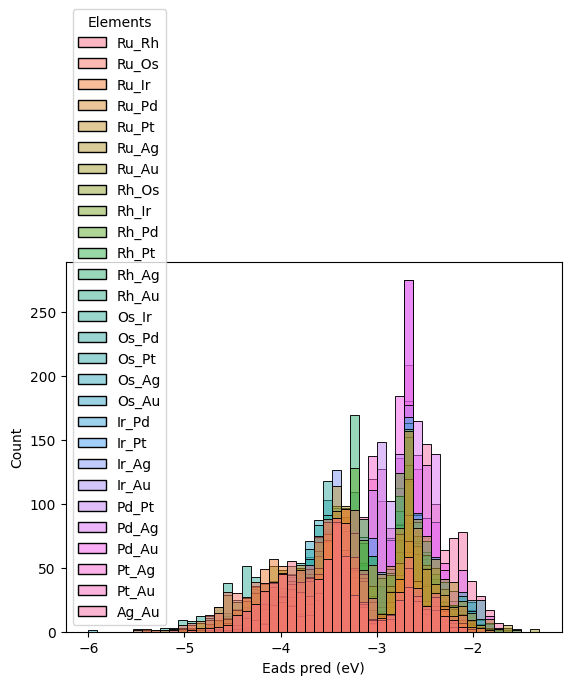

In [11]:
#Load discovery results

df = pd.read_csv('3_ele_optimization.csv')
with open('test.txt', 'r') as f:
    structure_predictions = json.loads(f.read())

#Visualize discovery results
sns.histplot(data=df,x='Eads pred (eV)',bins=50,hue='Elements')

In [14]:
#How to generate new more complex alloy ----------------------

#Select a specific datapoint, specify elements and visualize
idx =10585
e1='Rh'
e2='Pt'

rep1 = helpers.Symbol_to_index(e1,structure_predictions[idx])
rep2 = helpers.Symbol_to_index(e2,structure_predictions[idx])

atm1 = helpers.new_design(rep1,e1)
atm2 = helpers.new_design(rep2,e2,atm1)
view(atm2)
file_name = e1+'_'+e2+'_'+str(idx)+'.relax'

#write(file_name,atm2,format='espresso-in' )

#--------------------------------------------------------------

[5, 6] [10]

